# Binary Image Classification: Galaxy vs Star
This notebook trains a CNN to classify images as either galaxies or stars using **PyTorch**.

## 1. Import Libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Common parameters
img_height = 64
img_width = 64
batch_size = 32
data_dir = "images"

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device count: 1
Using device: cuda


## 2. Load and Prepare Data
Load images from the folder structure. PyTorch will use folder names as labels.

In [2]:
# Define transforms and create datasets
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # ensure 1-channel input
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]
)

# Consider converting images to greyscale in above section

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Train/val/test split (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total images: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

Classes: ['galaxy', 'star']
Total images: 3986
Train: 2790, Val: 597, Test: 599


## 3. Visualize Sample Images

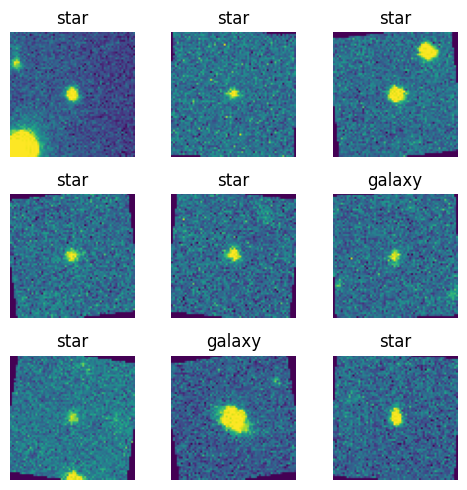

In [3]:
# Display 9 sample images
plt.figure(figsize=(5, 5))
# Take one batch from the training loader
images, labels = next(iter(train_loader))
for i in range(min(9, images.size(0))):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Make CNN

In [4]:
# Define the CNN model in PyTorch
embedding_count = 64  # 256‑dim embedding

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, embedding_count),  # now 256
            nn.ReLU(),
            nn.Linear(embedding_count, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = self.classifier[0](x)  # Flatten
        x = self.classifier[1](x)  # Linear -> 256‑dim
        x = self.classifier[2](x)  # ReLU
        return x

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)


## 5. Train the model

In [31]:
epochs = 20
train_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
epoch_times = []

for epoch in range(epochs):
    epoch_start = time.time()

    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total if total > 0 else 0
    train_acc = running_correct / total if total > 0 else 0

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels_all = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy().tolist())
            val_labels_all.extend(labels.cpu().numpy().tolist())
    val_acc = val_correct / val_total if val_total > 0 else 0
    if val_total > 0:
        val_f1 = f1_score(val_labels_all, val_preds, average="binary")
    else:
        val_f1 = 0.0

    epoch_time = time.time() - epoch_start
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    epoch_times.append(epoch_time)

    print(
        f"Epoch {epoch+1}/{epochs} - ",
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, ",
        f"Val acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Time: {epoch_time:.2f}s"
    )

total_training_time = sum(epoch_times)
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/20 -  Train loss: 0.2909, Train acc: 0.8803,  Val acc: 0.8559, Val F1: 0.9057, Time: 4.44s
Epoch 2/20 -  Train loss: 0.2834, Train acc: 0.8871,  Val acc: 0.8710, Val F1: 0.9143, Time: 7.73s
Epoch 3/20 -  Train loss: 0.2803, Train acc: 0.8864,  Val acc: 0.8526, Val F1: 0.9043, Time: 6.92s
Epoch 4/20 -  Train loss: 0.2782, Train acc: 0.8910,  Val acc: 0.8710, Val F1: 0.9134, Time: 6.28s
Epoch 5/20 -  Train loss: 0.2853, Train acc: 0.8849,  Val acc: 0.8141, Val F1: 0.8875, Time: 6.58s
Epoch 6/20 -  Train loss: 0.2856, Train acc: 0.8896,  Val acc: 0.8476, Val F1: 0.9041, Time: 6.97s
Epoch 7/20 -  Train loss: 0.2760, Train acc: 0.8903,  Val acc: 0.8476, Val F1: 0.9027, Time: 7.87s
Epoch 8/20 -  Train loss: 0.2704, Train acc: 0.8910,  Val acc: 0.8593, Val F1: 0.9104, Time: 5.41s
Epoch 9/20 -  Train loss: 0.2687, Train acc: 0.9011,  Val acc: 0.8693, Val F1: 0.9131, Time: 8.15s
Epoch 10/20 -  Train loss: 0.2679, Train acc: 0.8950,  Val acc: 0.8794, Val F1: 0.9224, Time: 8.63s
Epoch 11/

## 6. Collect embeddings

In [32]:
import numpy as np

def collect_embeddings(dataloader):
    model.eval()
    all_embeds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeds = model.embed(images)  # [batch, 128]
            all_embeds.append(embeds.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_embeds), np.concatenate(all_labels)

## 7. Visualize embedding

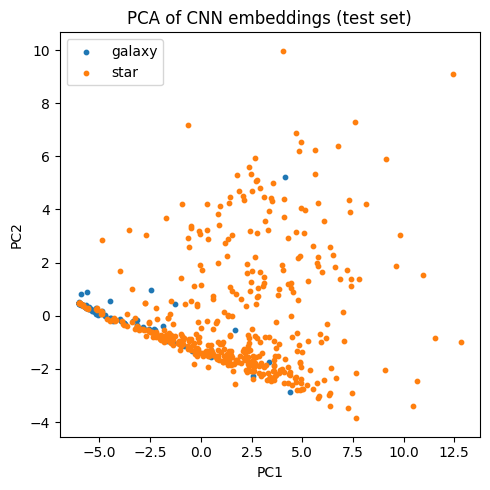

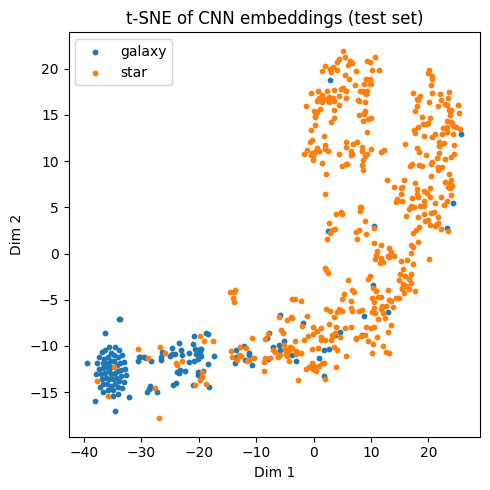

In [37]:
# 7. Visualize embedding
# Visualize embeddings with PCA / t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeds, labels = collect_embeddings(test_loader)

# PCA
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds)

# t-SNE
tsne = TSNE(n_components=2, init="random", learning_rate="auto")
embeds_tsne = tsne.fit_transform(embeds)

# --- PCA plot ---
plt.figure(figsize=(5, 5))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(embeds_pca[mask, 0], embeds_pca[mask, 1], s=10, label=class_names[c])
plt.legend()
plt.title("PCA of CNN embeddings (test set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# --- t-SNE plot ---
plt.figure(figsize=(5, 5))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(embeds_tsne[mask, 0], embeds_tsne[mask, 1], s=10, label=class_names[c])
plt.legend()
plt.title("t-SNE of CNN embeddings (test set)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

## 8. Linear probe

In [41]:
# To test quality of embedding

# 8. Linear probe with logistic regression on CNN embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

# Collect embeddings for each split
X_train, y_train = collect_embeddings(train_loader)
X_val,   y_val   = collect_embeddings(val_loader)
X_test,  y_test  = collect_embeddings(test_loader)

# Logistic regression = linear probe
probe = LogisticRegression(max_iter=1000)
probe.fit(X_train, y_train)

# Evaluate
for name, X, y in [("Train", X_train, y_train),
                   ("Val",   X_val,   y_val),
                   ("Test",  X_test,  y_test)]:
    y_pred = probe.predict(X)
    acc = accuracy_score(y, y_pred)
    f1_bin = f1_score(y, y_pred, average="binary")
    f1_w   = f1_score(y, y_pred, average="weighted")
    f1_m   = f1_score(y, y_pred, average="macro")
    print(f"{name}  -  acc: {acc:.4f}, f1: {f1_bin:.4f}, f1_weighted: {f1_w:.4f}, f1_macro: {f1_m:.4f}")

Train  -  acc: 0.9147, f1: 0.9445, f1_weighted: 0.9147, f1_macro: 0.8800
Val  -  acc: 0.8811, f1: 0.9217, f1_weighted: 0.8787, f1_macro: 0.8372
Test  -  acc: 0.8982, f1: 0.9324, f1_weighted: 0.8985, f1_macro: 0.8628


## 9. Encoding and Ansatz

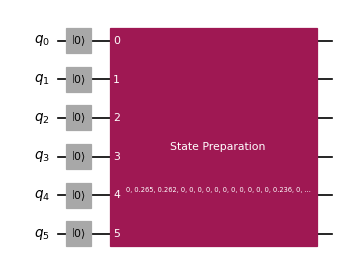

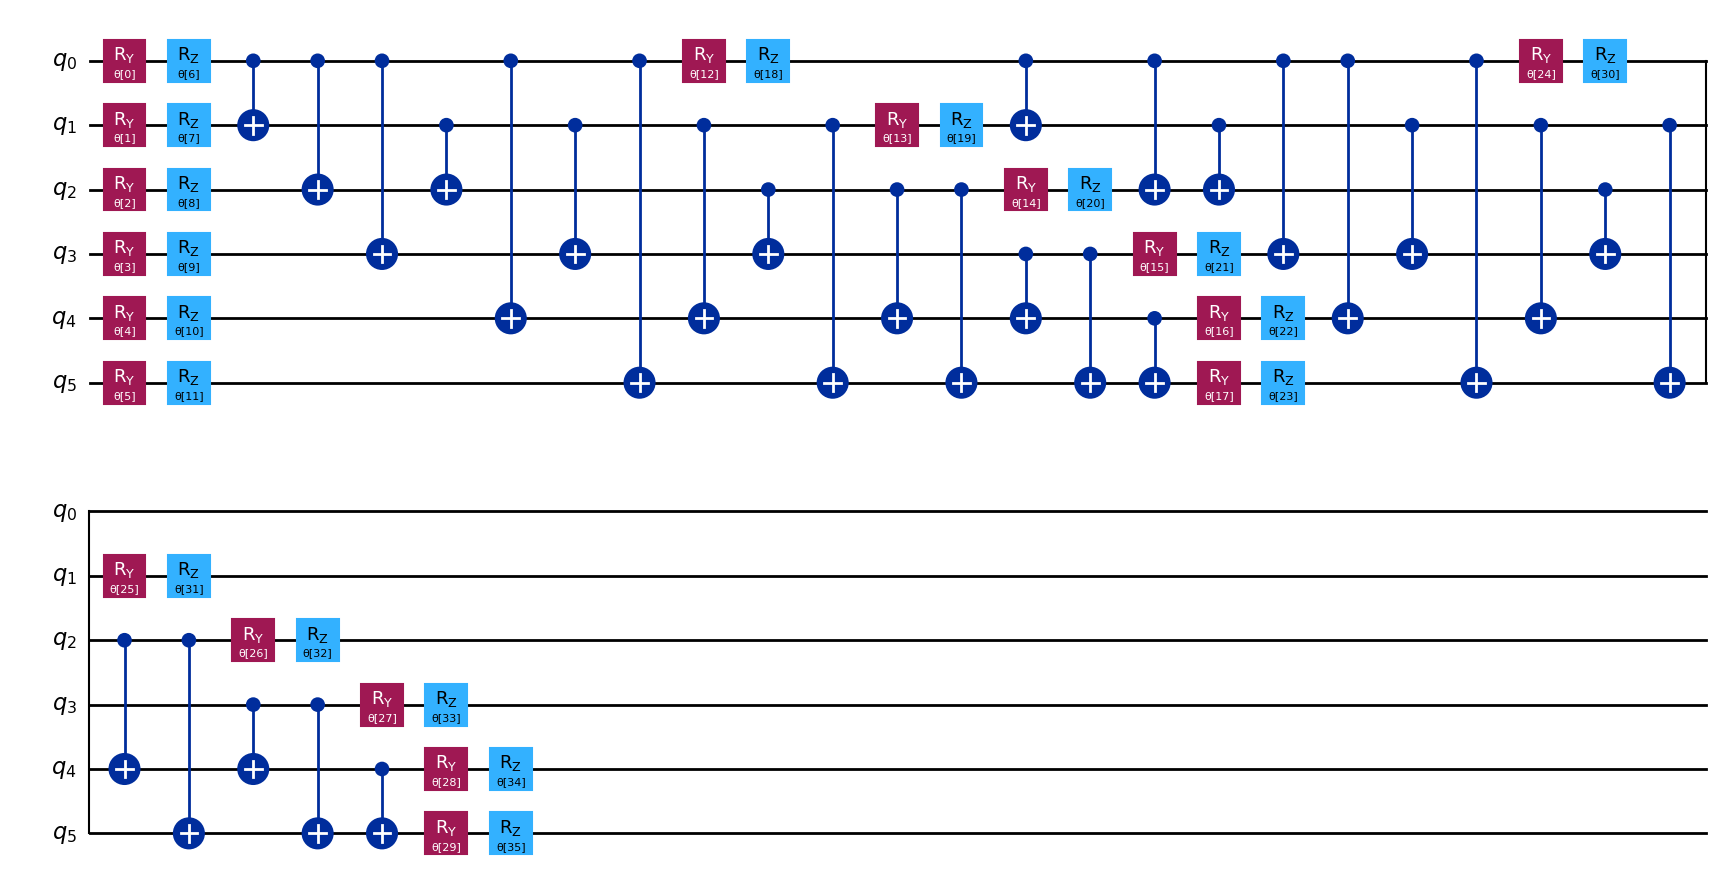

In [59]:
from qiskit.circuit.library import z_feature_map
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np
from qiskit.circuit.library import efficient_su2
import math
 
# One qubit per data feature
num_qubits = int(math.log2(embedding_count))

def amplitude_encode(x_vec: np.ndarray, num_qubits: int) -> QuantumCircuit:
    """Amplitude‑encode an arbitrary‑length real vector into num_qubits."""
    dim = 2 ** num_qubits
    x = np.asarray(x_vec, dtype=float).ravel()

    if x.size < dim:
        x = np.pad(x, (0, dim - x.size))
    elif x.size > dim:
        raise ValueError(
            f"Need at most {dim} features for {num_qubits}-qubit amplitude encoding, got {x.size}."
        )

    norm = np.linalg.norm(x)
    if norm == 0:
        # Encode as |0...0> if embedding is all zeros
        qc = QuantumCircuit(num_qubits)
        return qc
    
    state = x / norm
    qc = QuantumCircuit(num_qubits)
    qc.initialize(state, qc.qubits)
    return qc

qc = amplitude_encode(X_train[1], num_qubits)
display(qc.decompose().draw("mpl", scale=0.6))

# # Data encoding
# # Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
# feature_map = z_feature_map(num_qubits, parameter_prefix="a")
# fig = feature_map.decompose(reps=1).draw("mpl", scale=1)
# display(fig)

# Use EfficientSU2 as the variational ansatz
qnn_circuit = efficient_su2(
    num_qubits=num_qubits,
    reps=2,                 # increase for deeper ansatz
    entanglement="full",  # or "full", "circular", etc.
)

# Draw the circuit
qnn_circuit.draw("mpl")

## 12. Optimize for quantum execution

In [60]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_fez


In [61]:
from qiskit.circuit.library import XGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
target = backend.target

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

# circuit_ibm = pm.run(full_circuit)
# observable_ibm = observable.apply_layout(circuit_ibm.layout)

# circuit_ibm = pm.run(full_circuit)
# observable_ibm = observable.apply_layout(circuit_ibm.layout)

# # Transpiled depths
# print("Transpiled depth:", circuit_ibm.depth())
# print(
#     "Transpiled 2+ qubit depth:",
#     circuit_ibm.depth(lambda instr: len(instr.qubits) > 1),
# )

## 13. Execute

In [62]:
# ...existing code...
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator

# Globals for the QNN
ansatz = qnn_circuit
observables = observable
estimator = Estimator()  # statevector simulator
objective_func_vals = []
val_f1_history = []

def forward_amplitude(
    circuits,                 # list[QuantumCircuit]
    weight_params: np.ndarray,
    observable,
    estimator,
) -> np.ndarray:
    pubs = [(qc, observable, weight_params) for qc in circuits]
    job = estimator.run(pubs)
    res = job.result()
    evs = np.array([res[i].data.evs for i in range(len(pubs))], dtype=float).ravel()
    return evs

def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    global iteration
    global qnn_train_start

    # Training loss
    predictions = forward_amplitude(
        circuits=train_circuits,
        weight_params=weight_params,
        observable=observable,
        estimator=estimator,
    )
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    # Validation F1
    val_preds = forward_amplitude(
        circuits=val_circuits,
        weight_params=weight_params,
        observable=observable,
        estimator=estimator,
    )
    val_pred_labels = (val_preds >= 0).astype(int)
    f1_val = f1_score(val_target, val_pred_labels, average="binary")
    val_f1_history.append(f1_val)

    # Time elapsed
    elapsed = time.time() - qnn_train_start

    print(f"Iter: {iteration}, loss: {cost:.4f}, val F1: {f1_val:.4f}, elapsed: {elapsed:.2f}s")
    iteration += 1

    return cost

def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
num_epochs = 1

# Collect embeddings for train/val
X_train, y_train = collect_embeddings(train_loader)
X_val,   y_val   = collect_embeddings(val_loader)

input_params = X_train
target = y_train.astype(float)

val_input_params = X_val
val_target = y_val.astype(float)

qnn_train_start = time.time()

# Prebuild amplitude‑encoded + ansatz circuits for all training and validation points
train_circuits = [
    amplitude_encode(x, num_qubits=num_qubits).compose(ansatz, inplace=False)
    for x in input_params
]
val_circuits = [
    amplitude_encode(x, num_qubits=num_qubits).compose(ansatz, inplace=False)
    for x in val_input_params
]

for epoch in range(num_epochs):

    # optional: reset iteration counter per batch
    iteration = 0

    res = minimize(
        mse_loss_weights,
        weight_params,
        method="COBYLA",
        options={"maxiter": 200}
    )
    weight_params = res["x"]

# After training finishes, print total time
qnn_total_time = time.time() - qnn_train_start
print(f"Total QNN training time: {qnn_total_time:.2f} seconds")
# ...existing code...

Iter: 0, loss: 0.7972, val F1: 0.5515, elapsed: 33.71s
Iter: 1, loss: 0.7938, val F1: 0.5766, elapsed: 62.78s
Iter: 2, loss: 0.8112, val F1: 0.1678, elapsed: 93.93s
Iter: 3, loss: 0.8158, val F1: 0.6191, elapsed: 125.27s
Iter: 4, loss: 0.9028, val F1: 0.0350, elapsed: 153.18s
Iter: 5, loss: 0.8282, val F1: 0.1053, elapsed: 180.29s
Iter: 6, loss: 0.8923, val F1: 0.0459, elapsed: 207.77s
Iter: 7, loss: 0.8067, val F1: 0.3364, elapsed: 221.30s
Iter: 8, loss: 0.8870, val F1: 0.0494, elapsed: 246.56s
Iter: 9, loss: 0.7426, val F1: 0.7492, elapsed: 277.16s
Iter: 10, loss: 0.8430, val F1: 0.1142, elapsed: 306.15s
Iter: 11, loss: 0.8722, val F1: 0.0721, elapsed: 326.22s
Iter: 12, loss: 0.7636, val F1: 0.6868, elapsed: 347.03s
Iter: 13, loss: 0.6303, val F1: 0.8560, elapsed: 367.59s
Iter: 14, loss: 0.5977, val F1: 0.8594, elapsed: 382.39s
Iter: 15, loss: 0.5993, val F1: 0.8627, elapsed: 402.51s
Iter: 16, loss: 0.5508, val F1: 0.8914, elapsed: 428.52s
Iter: 17, loss: 0.7069, val F1: 0.8880, elap

## 14. Test

### Train data

In [66]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
# Use CNN embeddings and labels collected earlier
pred_train = forward_amplitude(
    circuits=train_circuits,
    weight_params=res["x"],
    observable=observable,
    estimator=estimator,
)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = 0
print(pred_train_labels)
print(y_train)
 
accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

f1 = f1_score(y_train, pred_train_labels, average="binary")
print(f"Train F1 score: {f1:.4f}")

[ 0.71712995 -0.14755058  0.40088726 ...  0.68308969 -0.14755058
  0.66890099]
[1. 0. 1. ... 1. 0. 1.]
[1 0 0 ... 1 0 1]
Train accuracy: 85.94982078853046%
Train F1 score: 0.9158


### Test data

In [67]:
test_circuits = [
    amplitude_encode(x, num_qubits=num_qubits).compose(ansatz, inplace=False)
    for x in X_test
]

pred_test = forward_amplitude(
    circuits=test_circuits,
    weight_params=res["x"],
    observable=observable,
    estimator=estimator,
)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = 0
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

f1 = f1_score(y_test, pred_test_labels, average="binary")
print(f"Test F1 score: {f1:.4f}")

[ 0.66338214  0.70318721  0.69374523  0.30228477  0.70888482  0.41009944
  0.70354775  0.69435685  0.50099061  0.53635455  0.65684026  0.68777986
  0.68097     0.69201281  0.65249196  0.70440383  0.02668323  0.68125993
  0.71607942  0.69770633 -0.14755058  0.69298017  0.70029695  0.69151945
  0.69143821  0.6760104   0.63853871  0.68628789 -0.14755058  0.66707077
  0.67147754  0.61639555  0.70917915  0.71543981  0.6800209   0.63491879
  0.6898257   0.69071344  0.6990676   0.71493575  0.47396985  0.71761364
 -0.14755058  0.16050697  0.55385399  0.68564611  0.59378121  0.54525204
  0.70484398  0.6712295   0.68185289  0.6638775   0.6837376   0.63876704
  0.68919311  0.62145646  0.69197016  0.49595227  0.62074631  0.53010216
  0.5953585   0.68914634  0.6909287   0.6030576   0.70313321  0.68698127
 -0.14755058  0.49066162  0.71935304  0.70003568  0.70188443  0.68650086
 -0.04893296  0.70021113  0.68509106  0.68800756 -0.14755058  0.66515936
  0.69927076  0.67656386  0.63375888  0.67022911  0

## 15. Convergence

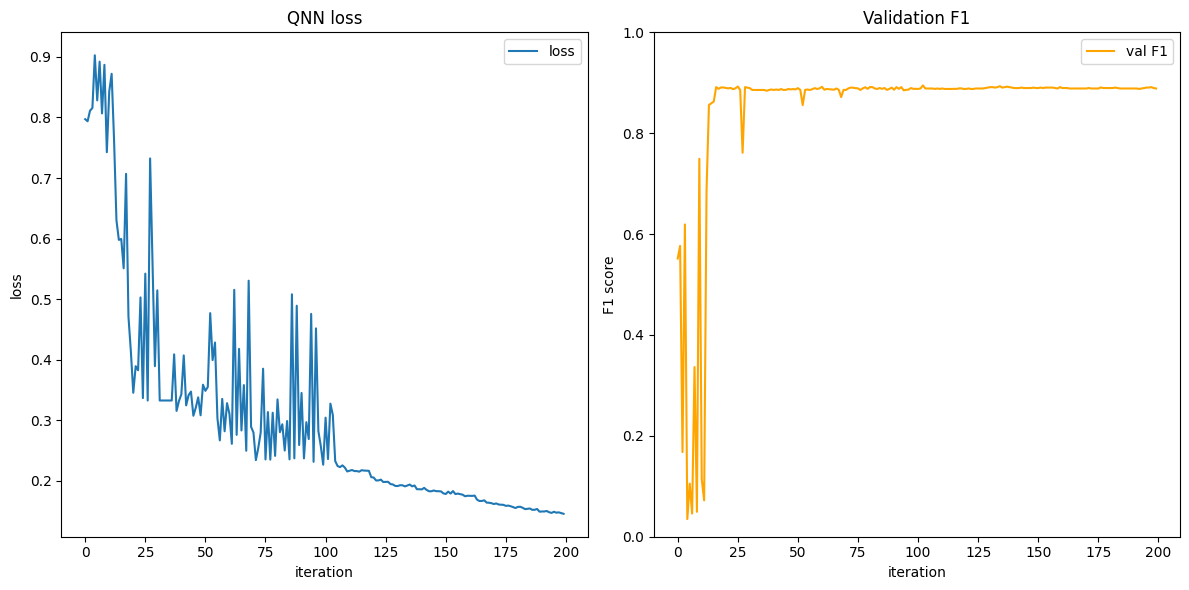

In [68]:
obj_func_vals_first = objective_func_vals
val_f1_vals_first = val_f1_history

plt.figure(figsize=(12, 6))

# Loss vs iteration
plt.subplot(1, 2, 1)
plt.plot(obj_func_vals_first, label="loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("QNN loss")
plt.legend()

# Validation F1 vs iteration
plt.subplot(1, 2, 2)
plt.plot(val_f1_vals_first, label="val F1", color="orange")
plt.xlabel("iteration")
plt.ylabel("F1 score")
plt.ylim(0, 1)
plt.title("Validation F1")
plt.legend()

plt.tight_layout()
plt.show()